## Step 1: Setup & Data Structures
We define strict Pydantic models for every node's output.

In [158]:
import os
import json
from typing import List, Optional, TypedDict
from pydantic import BaseModel, Field
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from langgraph.graph import END, StateGraph
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langgraph.graph import StateGraph, START, END

from huggingface_hub import InferenceClient
from dotenv import load_dotenv
from pydantic import BaseModel, Field, field_validator
from IPython.display import Image

In [159]:
# --- 1. Setup & Configuration (Kept Exact) ---
load_dotenv()

# Embeddings
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2",
    model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": True}
)

# Vector DB
VECTOR_DB_PATH = "./vector_db/faiss_lmkr"
try:
    vectorstore = FAISS.load_local(VECTOR_DB_PATH, embeddings, allow_dangerous_deserialization=True)
    retriever = vectorstore.as_retriever(search_kwargs={"k": 5})
except:
    print("⚠️ DB not found, creating dummy for execution safety.")
    vectorstore = FAISS.from_texts(["LMKR founded in 1994. GVERSE is a software brand."], embeddings)
    retriever = vectorstore.as_retriever()

# LLM Client
hf_client = InferenceClient(
    model="mistralai/Mistral-7B-Instruct-v0.2",
    token=os.getenv("HF_API_TOKEN")
)

# --- 2. Pydantic Models for Structured Output ---

class QueryAugmentation(BaseModel):
    """Output for Node 1: Retrieval Augmentation"""
    augmented_queries: List[str] = Field(
        description="List of 3 alternative versions of the user question to improve search coverage."
    )

class GeneratedAnswer(BaseModel):
    """Output for Node 2: Generation"""
    answer: str = Field(description="The response to the user.")
    sources_used: List[str] = Field(description="List of context chunks or titles used.")

    # FIX: Add this validator to handle cases where LLM returns a list for the answer
    @field_validator('answer', mode='before')
    @classmethod
    def flatten_list_answer(cls, v):
        if isinstance(v, list):
            return ", ".join(map(str, v))
        return v
        
class ValidationResult(BaseModel):
    """Output for Node 3: Validation"""
    is_valid: bool = Field(description="True if context was used correctly and no hallucinations found.")
    reason: str = Field(description="Explanation of validation failure or success.")

# --- 3. State Definition ---

class AgentState(TypedDict):
    question: str
    context_chunks: List[str]
    generated_answer: Optional[GeneratedAnswer]
    validation: Optional[ValidationResult]
    retry_count: int

## Step 2: Helper for Mistral JSON Enforcement
Since Mistral can be chatty, this helper ensures we get clean JSON.

In [160]:
def query_llm_structured(prompt_text: str, parser: PydanticOutputParser) -> Optional[BaseModel]:
    format_instructions = parser.get_format_instructions()
    
    # FIX 1: Stronger prompt to stop it from returning the Schema Definition
    final_prompt = f"""{prompt_text}
    
    IMPORTANT INSTRUCTIONS:
    1. Output ONLY a valid JSON object. 
    2. Do NOT output the schema definition or "properties" block. Output the actual data instance.
    3. Do NOT escape underscores (e.g., use "sources_used", NOT "sources\\_used").
    
    {format_instructions}
    """
    
    try:
        messages = [{"role": "user", "content": final_prompt}]
        response = hf_client.chat_completion(
            messages=messages,
            max_tokens=500,
            temperature=0.1
        )
        json_str = response.choices[0].message.content.strip()
        
        # Clean Markdown wrapping
        if "```json" in json_str:
            json_str = json_str.split("```json")[1].split("```")[0].strip()
        elif "```" in json_str:
            json_str = json_str.split("```")[1].split("```")[0].strip()

        # FIX 2: Manually fix the "sources\_used" error common in Mistral models
        json_str = json_str.replace(r"\_", "_")

        # FIX 3: Detect if model returned a Schema instead of Data (Node 1 Fix)
        # If the JSON looks like {"properties": {...}, "type": "object"}, it failed.
        # We can try to salvage it or just return None to trigger a retry/fallback.
        try:
            data = json.loads(json_str)
            if "properties" in data and "type" in data and data.get("type") == "object":
                print("⚠️ Model returned schema instead of data. Retrying parse...")
                # Sometimes models put the answer inside 'default' or 'example' fields of the schema, 
                # but usually it's best to just fail and let the fallback handle it.
                return None
        except:
            pass # Not valid JSON yet, let the parser handle the error
            
        return parser.parse(json_str)

    except Exception as e:
        print(f"❌ JSON Parsing/API Failed: {e}")
        # print(f"Raw: {json_str}") # Uncomment for debugging
        return None

## Step 3: Define The Router and The 3 Nodes

In [161]:
import requests
from bs4 import BeautifulSoup
import re
from typing import Literal

# --- 1. Tool Extraction from scraping.py ---

def get_soup(url: str):
    """Helper to get BeautifulSoup object safely."""
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91 Safari/537.36"
    }
    try:
        response = requests.get(url, headers=headers, verify=False, timeout=15)
        response.raise_for_status()
        return BeautifulSoup(response.content, "html.parser")
    except Exception as e:
        print(f"❌ Error fetching {url}: {e}")
        return None

def fetch_and_clean_body(url: str) -> str:
    soup = get_soup(url)
    if not soup: return ""
    
    # Remove non-content tags
    tags_to_remove = ["nav", "footer", "script", "style", "noscript", "iframe", "svg"]
    for tag in soup(tags_to_remove):
        tag.decompose()

    # Remove noise classes
    noise_classes = ["cookie", "popup", "newsletter", "signup", "login", "breadcrumb", "sidebar"]
    for noise in noise_classes:
        for element in soup.find_all(class_=re.compile(noise, re.IGNORECASE)):
            element.decompose()

    # Extract main content
    main_content = soup.find('main') or soup.find('article') or soup.find(id='content')
    if main_content:
        text = main_content.get_text(separator="\n")
    else:
        text = soup.get_text(separator="\n")
    return text

def clean_text_content(text: str) -> str:
    lines = text.split("\n")
    cleaned_lines = []
    NOISE_PHRASES = ["warning", "required", "skip to content", "all rights reserved"]

    for line in lines:
        stripped = line.strip()
        if len(stripped) < 3: continue
        if any(phrase in stripped.lower() for phrase in NOISE_PHRASES): continue
        cleaned_lines.append(stripped)

    return "\n".join(cleaned_lines)

def scrape_contact_tool():
    """Scrapes LMKR contact page and saves to file."""
    url = "https://lmkr.com/contact/"
    print(f"🕸️ Tool Triggered: Dynamically scraping {url}...")
    
    raw_text = fetch_and_clean_body(url)
    clean_text = clean_text_content(raw_text)
    
    # Store in a different file as requested
    file_path = "live_contact_data.txt"
    with open(file_path, "w", encoding="utf-8") as f:
        f.write(f"SOURCE: {url}\n\n{clean_text}")
        
    return clean_text

# --- 2. New Router Data Model ---

class RouteDecision(BaseModel):
    """Router output model."""
    destination: Literal["contact_node", "retrieve_node"] = Field(
        description="The next node to run. Choose 'contact_node' for address/email/phone queries. Choose 'retrieve_node' for everything else."
    )

In [162]:
# --- 5. Nodes ---

# NODE 1: RETRIEVE (With Augmentation)
def retrieve_node(state: AgentState):
    print("\n🔍 Node 1: Retrieve (Augmenting & Searching)...")
    question = state["question"]
    
    # 1. Multi-Query Augmentation
    parser = PydanticOutputParser(pydantic_object=QueryAugmentation)
    prompt = f"""
    User Question: {question}
    Task: Generate 3 different search query variations to find relevant info in a corporate vector DB.
    """
    structured_aug = query_llm_structured(prompt, parser)
    
    queries = [question]
    if structured_aug:
        queries.extend(structured_aug.augmented_queries)
        
    # 2. Retrieve & Deduplicate
    all_docs = []
    for q in queries:
        docs = retriever.invoke(q)
        all_docs.extend([d.page_content for d in docs])
    
    unique_context = list(set(all_docs))[:5] # Limit to top 5 unique chunks

    print (f"   Retrieved {len(unique_context)} unique context chunks.")
    open("retrieved_context.txt", "w", encoding="utf-8").write("".join(unique_context))
    
    return {"context_chunks": unique_context}

# NODE 2: GENERATE (Safety & Context Focused)
def generate_node(state: AgentState):
    print("\n✍️ Node 2: Generate Answer...")
    context = "\n---\n".join(state["context_chunks"])
    question = state["question"]
    
    parser = PydanticOutputParser(pydantic_object=GeneratedAnswer)
    prompt = f"""
    Context Data:
    {context}
    
    User Question: {question}
    
    Instructions:
    1. Answer the question using ONLY the provided Context Data.
    2. If the answer is not in the context, state "I do not have enough information."
    3. Do not hallucinate or make up facts.
    4. Maintain a professional tone.
    """
    
    structured_response = query_llm_structured(prompt, parser)
    
    # Fallback if generation fails
    if not structured_response:
        # CHANGE: sources_used must be a list now
        structured_response = GeneratedAnswer(
            answer="Error generating response.", 
            sources_used=["None"]
        )
        
    return {"generated_answer": structured_response}

# NODE 3: VALIDATE (Hallucination & Structure Check)
def validate_node(state: AgentState):
    print("\n🛡️ Node 3: Validate...")
    generation = state["generated_answer"]
    context = "\n---\n".join(state["context_chunks"])
    question = state["question"]
    
    parser = PydanticOutputParser(pydantic_object=ValidationResult)
    prompt = f"""
    Context: {context}
    Generated Answer: {generation.answer}
    
    Task: Validate the answer based on these strict rules:
    1. Was the context actually used?
    2. Are there any hallucinations (facts not in context)?
    3. Is the structure correct?
    4. If the answer is "I do not have enough information.", it is valid only if the context lacks relevant info.
    
    Return valid=True only if all checks pass. Otherwise return false
    """
    
    validation = query_llm_structured(prompt, parser)
    
    if not validation:
        # Default to fail if validator breaks
        validation = ValidationResult(is_valid=False, reason="Validation process failed.")
        
    return {"validation": validation}

# NODE 4: ROUTER 

def router_node(state: AgentState):
    print("\n🚦 Router: Analyzing User Intent...")
    question = state["question"]
    
    parser = PydanticOutputParser(pydantic_object=RouteDecision)
    prompt = f"""
    User Question: {question}
    
    Role: You are a Router. 
    Task: Decide where to send this query.
    
    Rules:
    1. If the user asks for Contact Info, Phone Numbers, Emails, Addresses, or Office Locations for LMKR, route to 'contact_node'.
    2. For ANY other topic (Software, Geology, Company History, Solutions), route to 'retrieve_node'.
    """
    
    decision = query_llm_structured(prompt, parser)
    
    # Fallback default
    if not decision:
        return {"destination": "retrieve_node"}
        
    print(f"   👉 Routing to: {decision.destination}")
    return {"destination": decision.destination} # Pass decision to conditional edge

def contact_node(state: AgentState):
    print("\n📞 Node: Contact (Scrape & Generate)...")
    
    # 1. Scrape Tool
    contact_data = scrape_contact_tool()
    
    # 2. Generate Answer (In the same node)
    question = state["question"]
    parser = PydanticOutputParser(pydantic_object=GeneratedAnswer)
    
    prompt = f"""
    Live Scraped Data:
    {contact_data}
    
    User Question: {question}
    
    Instructions:
    Extract the contact details requested by the user from the scraped data above.
    Format it clearly.
    """
    
    structured_response = query_llm_structured(prompt, parser)
    
    # Fallback
    if not structured_response:
        structured_response = GeneratedAnswer(
            answer="I scraped the contact page but couldn't parse the details.",
            sources_used=["https://lmkr.com/contact/"]
        )
        
    return {"generated_answer": structured_response}

## Step 4: Build Graph & Logic

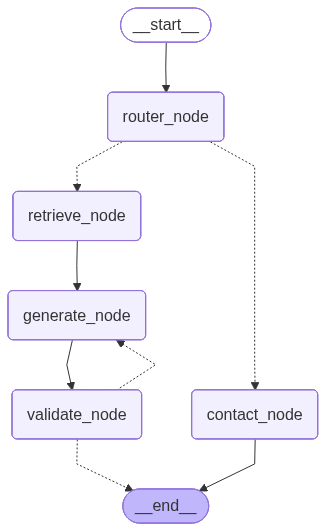

In [163]:
# --- 6. Edge Logic ---

def router(state: AgentState):
    validation = state["validation"]
    retry_count = state.get("retry_count", 0)
    
    if validation and validation.is_valid:
        print("✅ Validation Passed.")
        return END
    
    if retry_count >= 2:
        print("🛑 Max retries reached. Returning best effort.")
        return END
        
    print(f"🔄 Validation Failed: {validation.reason if validation else 'Unknown'}. Regenerating...")
    return "generate_node" # Loop back to generation

# --- 7. Build Updated Graph ---

workflow = StateGraph(AgentState)

# Add All Nodes
workflow.add_node("router_node", router_node)
workflow.add_node("contact_node", contact_node)
workflow.add_node("retrieve_node", retrieve_node)   # Existing RAG Node
workflow.add_node("generate_node", generate_node)   # Existing RAG Node
workflow.add_node("validate_node", validate_node)   # Existing RAG Node

# Set Entry Point
workflow.set_entry_point("router_node")

# Define Conditional Logic for Router
def route_logic(state):
    # The router_node returns a dict, but StateGraph merges it into state.
    # We check the temporary key or passed value. 
    # Since router_node output is merged, we can read the decision from the return value in the function wrapper 
    # OR simpler: just re-run logic inside conditional edge if needed, 
    # BUT better pattern: The router output determines the path.
    
    # We will assume 'router_node' passes the destination in the state or we map logic here.
    # Actually, let's use the node output directly in the edge function.
    return state.get("destination", "retrieve_node") # This requires us to update AgentState TypedDict

# Update State to include destination for routing (Optional, or just return from node)
# Let's add 'destination' to AgentState for safety
class AgentState(TypedDict):
    question: str
    context_chunks: List[str]
    generated_answer: Optional[GeneratedAnswer]
    validation: Optional[ValidationResult]
    retry_count: int
    destination: Optional[str] # <--- Added this

# Conditional Edge
workflow.add_conditional_edges(
    "router_node",
    lambda x: x["destination"], # Read the decision made by the router node
    {
        "contact_node": "contact_node",
        "retrieve_node": "retrieve_node"
    }
)

# Connect Contact Flow (Ends after generation as requested)
workflow.add_edge("contact_node", END)

# Connect Standard RAG Flow (Retrieve -> Generate -> Validate)
workflow.add_edge("retrieve_node", "generate_node")
workflow.add_edge("generate_node", "validate_node")

# Connect Validation Logic (Loop or End)
workflow.add_conditional_edges(
    "validate_node",
    router, # Your existing router function for validation loops
    {
        END: END,
        "generate_node": "generate_node"
    }
)

app = workflow.compile()

# Visualize
from IPython.display import Image
Image(app.get_graph().draw_mermaid_png())

## Step 5: Execution

In [167]:
# --- 8. Execution Test ---

print("🚀 Starting RAG Pipeline (Retrieve -> Generate -> Validate)...")

initial_state = {
    "question": "Who is the contact person listed for Canada and Latin America sales?", 
    "retry_count": 0,
    "context_chunks": [],
    "generated_answer": None,
    "validation": None
}

final_state = app.invoke(initial_state)

print("\n🎉 Final Result:")
if final_state.get('generated_answer'):
    print(f"Answer: {final_state['generated_answer'].answer}")
    
    # FIX: Check if validation actually ran
    if final_state.get('validation'):
        status = 'Pass' if final_state['validation'].is_valid else 'Fail (Max Retries)'
        print(f"Validation Status: {status}")
    else:
        print("Validation Status: N/A (Direct Contact Route)")
        
    print(f"Source chunks Used: {final_state['generated_answer'].sources_used}")
else:
    print("Process failed to generate an answer.")

🚀 Starting RAG Pipeline (Retrieve -> Generate -> Validate)...

🚦 Router: Analyzing User Intent...
   👉 Routing to: contact_node

📞 Node: Contact (Scrape & Generate)...
🕸️ Tool Triggered: Dynamically scraping https://lmkr.com/contact/...


c:\Users\sarkazmi\AppData\Local\Programs\Python\Python313\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lmkr.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



🎉 Final Result:
Answer: Russ Phillips
Validation Status: N/A (Direct Contact Route)
Source chunks Used: ['Canada', 'Latin America']
